# National longitudal survery (NLS) dataset

In [1]:
import torch
import confounding_robust_inference as cri
from confounding_robust_inference.estimators.misc import normalize_p_t

In [2]:
from matplotlib import pyplot as plt
from matplotlib.cm import tab10

plt.style.use("seaborn-whitegrid")

/tmp/ipykernel_1094965/1438594505.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [3]:
# setup toy policy and data
_ = torch.random.manual_seed(0)
TORCH_DTYPE = cri.utils.types.get_default_torch_dtype()
policy = cri.policies.ATEPolicy(base_treatment=0, target_treatment=1)
data = cri.data.NLSDataDornGuo2022()
Y, T, X, _, p_t, _ = data.sample()
p_t = normalize_p_t(p_t, T)

## Non-robust policy value

In [4]:
# Union membership (T) might positively impact the wage (Y)!
estimator = cri.estimators.IPWEstimator()
estimator.fit(Y, T, X, p_t, policy)
estimator.predict()

tensor(0.2271, dtype=torch.float64)

## Robust policy value

In [5]:
# Even if we consider possibility of confounding, union membership (T) may still affect the wage (Y).
estimator = cri.estimators.KCMCEstimator(const_type="Tan_box", Gamma=1.5, D=10)
estimator.fit(Y, T, X, p_t, policy)
estimator.predict()

tensor(0.1085, dtype=torch.float64)

## Visualize the bounds by KCMC, ZSB, and QB estimators

In [6]:
Gammas = [1 + i / 10 for i in range(11)]


def get_bound(estimator_type, direction, Gamma):
    estimator = {
        "KCMC": cri.estimators.KCMCEstimator(
            const_type="Tan_box", Gamma=Gamma, D=20, rescale_by_policy_prob=True
        ),
        "ZSB": cri.estimators.ZSBEstimator(const_type="Tan_box", Gamma=Gamma),
        "QB": cri.estimators.QBEstimator(const_type="Tan_box", Gamma=Gamma, D=20),
    }[estimator_type]
    if direction == "lower":
        return estimator.fit(Y, T, X, p_t, policy).predict()
    elif direction == "upper":
        return -estimator.fit(-Y, T, X, p_t, policy).predict()
    else:
        raise ValueError


lower_bounds_kcmc = [get_bound("KCMC", "lower", Gamma) for Gamma in Gammas]
upper_bounds_kcmc = [get_bound("KCMC", "upper", Gamma) for Gamma in Gammas]

lower_bounds_zsb = [get_bound("ZSB", "lower", Gamma) for Gamma in Gammas]
upper_bounds_zsb = [get_bound("ZSB", "upper", Gamma) for Gamma in Gammas]

lower_bounds_qb = [get_bound("QB", "lower", Gamma) for Gamma in Gammas]
upper_bounds_qb = [get_bound("QB", "upper", Gamma) for Gamma in Gammas]

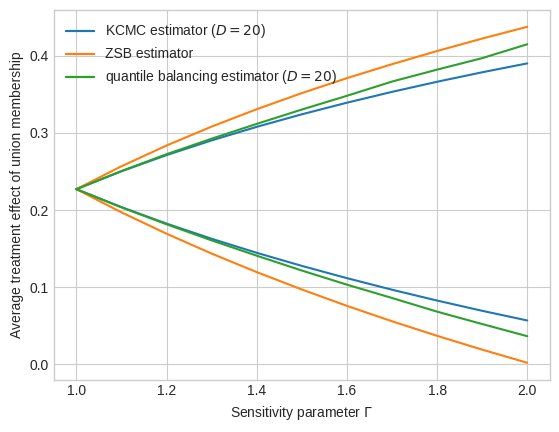

In [7]:
lower_line_kcmc = plt.plot(Gammas, lower_bounds_kcmc, color=tab10(0))[0]
upper_line_kcmc = plt.plot(Gammas, upper_bounds_kcmc, color=tab10(0))[0]
lower_line_zsb = plt.plot(Gammas, lower_bounds_zsb, color=tab10(1))[0]
upper_line_zsb = plt.plot(Gammas, upper_bounds_zsb, color=tab10(1))[0]
lower_line_qb = plt.plot(Gammas, lower_bounds_qb, color=tab10(2))[0]
upper_line_qb = plt.plot(Gammas, upper_bounds_qb, color=tab10(2))[0]

plt.legend(
    [
        (lower_line_kcmc, upper_line_kcmc),
        (lower_line_zsb, upper_line_zsb),
        (lower_line_qb, upper_line_qb),
    ],
    [r"KCMC estimator ($D=20$)", "ZSB estimator", r"quantile balancing estimator ($D=20$)"],
    loc="upper left",
)
plt.xlabel(r"Sensitivity parameter $\Gamma$")
plt.ylabel("Average treatment effect of union membership")
plt.savefig("fig/nls_data_kcmc_vs_zsb_vs_qb.pdf")